In [23]:
import datetime
import pandas as pd 
import krakenex

# ------ CONNECT TO API USING API KEY -------

k = krakenex.API()
path = '/Users/boina/.config/clikraken/kraken1.key'
k.load_key(path)

# ---- FIRST PART ------

Ledger = k.query_private('Ledgers')

# print(json_response) with trades
df = pd.DataFrame(Ledger['result']['ledger'])

# transpose dataframe
df = df.T

# change format of currencies and add a new column with correct format

currency_kraken = []

for currency in df['asset']:
    first_4  = currency[:4]
    if first_4[:1] == 'X'or'Z':
        currency_kraken.append(first_4[-3:])
    else:
        currency_kraken.append(first_4[:3])

df['currency'] = currency_kraken
df['amount'] = df.amount.astype(float)
df['balance'] = df.balance.astype(float)
df['fee'] = df.fee.astype(float)

# convert time (unix timestamp) to date
df['date'] = pd.to_datetime(df['time'], unit='s')

# sort values by currency and date
df = df.sort_values(by=['date','currency'],ascending=[0, 1])

# convert date column to format YYYY-MM-DD
df['date'] = df['date'].apply(lambda t: t.strftime('%Y-%m-%d'))


# drop time column and asset
df.drop(['time','asset'], axis = 1, inplace = True)


# ---- SECOND PART : CREATE A PIVOTED DATAFRAME WITH LESS INFO ------

df1 = pd.DataFrame(df[['balance','currency','date']])
# reset index
df1 = df1.reset_index()
# drop index column
df1.drop(['index'], axis = 1, inplace = True)

# pivot table : set index as dates, create columns with currency names and fill cells with balance
df1 = pd.pivot_table(df1, index= 'date', columns='currency', values="balance", aggfunc='first')

# fill future missing values with previous balance

df1 = df1.fillna(method='ffill')

# fill remaining missing values with 0 (i.e the currency was not bought in the past)
df1 = df1.fillna(value=0)

df1['date_transactions'] = df1.index

# ---- THIRD PART : CREATE A DATAFRAME WITH DATES BETWEEN 2017-09-15 AND TODAY ------

#set date intervals
start_date = '2017-09-15'
today = datetime.datetime.today()

#create a list with dates between the two intervals
datelist = pd.date_range(start = start_date , end = today).tolist()

#create a dataframe
df2 = pd.DataFrame(datelist)

#rename column to date
df2.columns = ['date']

# convert date column to format YYYY-MM-DD
df2['date'] = df2['date'].apply(lambda t: t.strftime('%Y-%m-%d'))

df2 = df2.set_index('date')

df2['date_transactions'] = df2.index

# ---- FOURTH PART : CREATE A DATAFRAME WITH HOLDINGS PER CURRENCY AND PER DAY ------

#merge the two dataframes on the column date_transactions
new_df = pd.merge(df1, df2, on='date_transactions', how='outer')

new_df = new_df.sort_index()
# sort values by currency and date

# sort values by date_transactions
new_df = new_df.sort_values(by=['date_transactions'],ascending=[1])

# fill future missing values with previous balance

new_df = new_df.fillna(method='ffill')

# replace XBT with BTC

new_df.rename(columns={'XBT': 'BTC'}, inplace=True)

# drop date_transactions column

new_df.drop(['date_transactions'], axis = 1, inplace = True)

# sort column names 

new_df = new_df.sort_index(axis=1)

list_coin = new_df.columns.values
dict_coin = { i : 'coin' for i in list_coin }

if "EUR" in dict_coin:
    del dict_coin["EUR"]

new_df.tail(30)

,BCH,BTC,EOS,ETC,ETH,EUR,LTC,XLM,XMR,XRP
289,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
290,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
291,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
292,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
293,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
294,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
295,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
296,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
297,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0
298,0.379845,0.200552,12.816,7.0,8.515791,373.5463,12.8814,941.593821,1.0,1278.0


In [24]:
import pandas as pd
from datetime import date, timedelta
import requests
import time

CURRENCIES = dict_coin
TARGET_CURRENCY = 'EUR'
NUMBER_OF_DAYS = str(new_df.index[-1])

PRICE_HISTORY_BASE_URL = 'https://min-api.cryptocompare.com/data/histoday'
REQUEST_PARAMS = '?fsym={source_currency}&tsym={target_currency}&limit=' + NUMBER_OF_DAYS +'&aggregate=1&e=Kraken'
TEMPLATE_REQUEST_URL = PRICE_HISTORY_BASE_URL + REQUEST_PARAMS

# Obtain historical data from the beginning of time for each currency
currency_dataframe = {}
for currency, symbol in CURRENCIES.items():
    request_url = TEMPLATE_REQUEST_URL.format(source_currency = currency, target_currency = TARGET_CURRENCY)
    print('Fetching historical market data for {} ({} -> {}) ....'.format(currency, symbol, TARGET_CURRENCY))
    print('Request URL :', request_url)
    json_response = requests.get(url = request_url).json()
    if json_response['Response'] == 'Error':
        print('Failed to fetch historical market data for {} ({} -> {}) !, Error Message : {}'
              .format(currency, symbol, TARGET_CURRENCY, json_response['Message']))
    else:
        # print(json_response)
        df_hist = pd.DataFrame(json_response['Data'])
        # convert time (unix timestamp) to date
        df_hist['date'] = pd.to_datetime(df_hist['time'], unit = 's')
        # drop time column
        df_hist.drop('time', axis = 1, inplace = True)
        # set date column as index
        df_hist.set_index('date', inplace = True)
        
        # volumefrom : trading volume of source currency traded (ex: BTC)
        # volumeto : trading volume of target currency traded (ex: USD)
        # average price of 1 unit of the source currency in the target currency = volumeto / volumefrom
        df_hist.rename(columns = {'open': 'market_open', 'close': 'market_close',
                             'low': 'market_low', 'high': 'market_high',
                             'volumefrom': 'trading_volume_source_currency', 
                             'volumeto': 'trading_volume_target_currency'}, inplace = True)
        currency_dataframe[currency] = df_hist
        print('Successfully fetched historical market data for {} !'.format(currency, symbol))
    # sleep for 1s to avoid hitting max rate limit per second
    time.sleep(1)

#create a empty list for all the currency dataframes 
df_hist1=[]
#group together all currency dataframes in one dataframe
for currency in currency_dataframe:
    df_hist1.append(currency_dataframe[currency])

#concatenate every column of the new data frame   
df_hist2=pd.concat(df_hist1,axis=1)

#drop every column but 'market_close' ones
df_hist2=df_hist2.loc[:,'market_close']

#create a new list to rename 'market_close' columns
list_market_close=[]
for a in CURRENCIES.keys():
    market_close = '{}_market_close'.format(a)
    list_market_close.append(market_close)

#replace dataframe columns
df_hist2.columns = list_market_close

#add a EUR_market_close column equals to 1
df_hist2['EUR_market_close'] = 1
df_hist2['EUR_market_close'] = df_hist2.EUR_market_close.astype(float)

#sort columns
df_hist2 = df_hist2.sort_index(axis=1)

#Multiply columns from the two dataframes
merged_df  = pd.DataFrame(new_df.values*df_hist2.values, columns=new_df.columns, index=df_hist2.index)

#Add a new column with the total valuation 
merged_df ['Total_valuation'] = merged_df.iloc[:, 0:].sum(1)

merged_df.tail()

Fetching historical market data for BCH (coin -> EUR) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=BCH&tsym=EUR&limit=318&aggregate=1&e=Kraken
Successfully fetched historical market data for BCH !
Fetching historical market data for BTC (coin -> EUR) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=EUR&limit=318&aggregate=1&e=Kraken
Successfully fetched historical market data for BTC !
Fetching historical market data for EOS (coin -> EUR) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=EOS&tsym=EUR&limit=318&aggregate=1&e=Kraken
Successfully fetched historical market data for EOS !
Fetching historical market data for ETC (coin -> EUR) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ETC&tsym=EUR&limit=318&aggregate=1&e=Kraken
Successfully fetched historical market data for ETC !
Fetching historical market data for ETH (coin -> EUR) ....
Request URL : https://min-api.cryptocompare.c

,BCH,BTC,EOS,ETC,ETH,EUR,LTC,XLM,XMR,XRP,Total_valuation
date,,,,,,,,,,,
2018-07-26,262.662658,1363.833617,91.24992,100.31,3376.596274,373.5463,923.596380,250.369797,117.39,492.9246,7352.479546
2018-07-27,266.840951,1405.608592,92.53152,101.85,3423.773755,373.5463,931.067592,256.113519,120.28,499.4424,7471.054630
2018-07-28,267.714594,1414.914204,92.01888,102.13,3421.474492,373.5463,930.037080,253.288738,119.15,500.8482,7475.122487
2018-07-29,269.917694,1412.246862,92.14704,101.64,3401.377225,373.5463,926.945544,248.674928,116.67,497.9088,7441.074393
2018-07-30,256.964987,1360.745116,82.27872,100.73,3266.742570,373.5463,892.681020,226.735792,110.32,483.9786,7154.723106


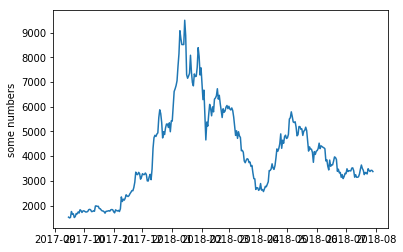

In [113]:
import matplotlib.pyplot as plt 
plt.plot(merged_df['ETH'])
plt.ylabel('some numbers')
plt.show()

In [112]:
merged_df.to_excel('Total valuation.xlsx')

In [5]:
dict_coin = new_df.columns.values

In [11]:
print(CURRENCIES)

['BCH' 'BTC' 'EOS' 'ETC' 'ETH' 'EUR' 'LTC' 'XLM' 'XMR' 'XRP']


In [14]:
list_coin = new_df.columns.values
dict_coin = { i : 'coin' for i in list_coin }

if "EUR" in dict_coin:
    del dict_coin["EUR"]

In [15]:
print(dict_coin)

{'BCH': 'coin', 'BTC': 'coin', 'EOS': 'coin', 'ETC': 'coin', 'ETH': 'coin', 'LTC': 'coin', 'XLM': 'coin', 'XMR': 'coin', 'XRP': 'coin'}


In [18]:
import datetime
import pandas as pd 
import krakenex

# ------ CONNECT TO API USING API KEY -------

k = krakenex.API()
path = '/Users/boina/.config/clikraken/kraken1.key'
k.load_key(path)

# ---- FIRST PART ------

Ledger = k.query_private('Ledgers')

# print(json_response) with trades
df = pd.DataFrame(Ledger['result']['ledger'])

# transpose dataframe
df = df.T

# change format of currencies and add a new column with correct format

currency_kraken = []

for currency in df['asset']:
    first_4  = currency[:4]
    if first_4[:1] == 'X'or'Z':
        currency_kraken.append(first_4[-3:])
    else:
        currency_kraken.append(first_4[:3])

df['currency'] = currency_kraken
df['amount'] = df.amount.astype(float)
df['balance'] = df.balance.astype(float)
df['fee'] = df.fee.astype(float)

# convert time (unix timestamp) to date
df['date'] = pd.to_datetime(df['time'], unit='s')

# sort values by currency and date
df = df.sort_values(by=['date','currency'],ascending=[0, 1])

# convert date column to format YYYY-MM-DD
df['date'] = df['date'].apply(lambda t: t.strftime('%Y-%m-%d'))


# drop time column and asset
df.drop(['time','asset'], axis = 1, inplace = True)


# ---- SECOND PART : CREATE A PIVOTED DATAFRAME WITH LESS INFO ------

df1 = pd.DataFrame(df[['balance','currency','date']])
# reset index
df1 = df1.reset_index()
# drop index column
df1.drop(['index'], axis = 1, inplace = True)

# pivot table : set index as dates, create columns with currency names and fill cells with balance
df1 = pd.pivot_table(df1, index= 'date', columns='currency', values="balance", aggfunc='first')

# fill future missing values with previous balance

df1 = df1.fillna(method='ffill')

# fill remaining missing values with 0 (i.e the currency was not bought in the past)
df1 = df1.fillna(value=0)

df1['date_transactions'] = df1.index

# ---- THIRD PART : CREATE A DATAFRAME WITH DATES BETWEEN 2017-09-15 AND TODAY ------

#set date intervals
start_date = '2017-09-15'
today = datetime.datetime.today()

#create a list with dates between the two intervals
datelist = pd.date_range(start = start_date , end = today).tolist()

#create a dataframe
df2 = pd.DataFrame(datelist)

#rename column to date
df2.columns = ['date']

# convert date column to format YYYY-MM-DD
df2['date'] = df2['date'].apply(lambda t: t.strftime('%Y-%m-%d'))

df2 = df2.set_index('date')

df2['date_transactions'] = df2.index

In [22]:
df1.head()

,balance,currency,date
LOHWNW-IMOB4-HLRBW4,12.816000,EOS,2018-04-19
LNJ4NR-MNHFT-PAVVRL,373.546300,EUR,2018-04-19
LBYB5P-HQVNN-Y5QHHD,7.000000,ETC,2018-04-19
LUFCPL-2PW3S-7AEH3R,425.059900,EUR,2018-04-19
L7EEOP-PMMUL-VXAOHY,941.593821,XLM,2018-04-18
